# Analyze the alignement quality of our xenium patches / training_28

In [1]:
import os
import json
import io
import zipfile
import pandas as pd
import spatialdata as sd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba
from scipy.sparse import csr_matrix
import h5py

## Helper functions

In [2]:
def build_df_metrics(output_cellvit_folder, slide_id):
    
    json_path = os.path.join(output_cellvit_folder, f'{slide_id}/inference_results.json')
    with open(json_path, 'r') as file:
        metric_json_file = json.load(file)

    df_metrics = pd.DataFrame.from_dict(metric_json_file['image_metrics'], orient='index')

    df_metrics.reset_index(inplace=True)
    df_metrics.rename(columns={'index': 'patch_id'}, inplace=True)

    df_metrics['patch_id'] = df_metrics['patch_id'].str.replace('.png', '', regex=False)

    return df_metrics

In [3]:
def plot_all_metrics(df_metrics):

    metrics = ['Dice', 'Jaccard', 'bPQ']

    plt.figure(figsize=(9, 3))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.histplot(df_metrics.loc[df_metrics["Dice"] != -1, metric], bins=30, kde=True, color='blue')
        plt.title(f'{metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [4]:
def load_imgfile(img_zip_path, img_name):
    with zipfile.ZipFile(img_zip_path, 'r') as img_zip:
        img_data = img_zip.read(img_name)
        img = Image.open(io.BytesIO(img_data))
    return np.array(img).astype(np.uint8)


def load_maskfile(mask_zip_path, mask_name):
        
    with zipfile.ZipFile(mask_zip_path, 'r') as mask_zip:
        
        with mask_zip.open(mask_name) as mask_file:
            # Load the .npz file using numpy
            data = np.load(io.BytesIO(mask_file.read()), allow_pickle=True)
            
            # Reconstruct sparse matrices
            inst_map_sparse = csr_matrix(
                (data["inst_map_data"], data["inst_map_indices"], data["inst_map_indptr"]),
                shape=data["inst_map_shape"]
            )
            type_map_sparse = csr_matrix(
                (data["type_map_data"], data["type_map_indices"], data["type_map_indptr"]),
                shape=data["type_map_shape"]
            )

            # Convert sparse matrices to dense arrays
            inst_map = inst_map_sparse.toarray().astype(np.int32)
            type_map = type_map_sparse.toarray().astype(np.int32)
    return inst_map, type_map

In [5]:
class H5FileSingleton:
    _instances = {}

    @classmethod
    def get_instance(cls, file_path):
        if file_path not in cls._instances:
            cls._instances[file_path] = h5py.File(file_path, 'r')
        return cls._instances[file_path]

    @classmethod
    def close_all(cls):
        for file_path, h5_file in cls._instances.items():
            if h5_file is not None:
                h5_file.close()
        cls._instances.clear()

In [6]:
def load_sparse_h5(file_path, image_name):
    """
    Load a sparse CSR matrix for a specific key (image_name) from a shared HDF5 file.
    
    Parameters:
        file_path (str): Path to the global HDF5 file.
        image_name (str): Key for the specific patch in the file.
    
    Returns:
        csr_matrix: Reconstructed sparse matrix.
    """
    h5_file = H5FileSingleton.get_instance(file_path)
    data = h5_file[f"{image_name}_data"][:]
    indices = h5_file[f"{image_name}_indices"][:]
    indptr = h5_file[f"{image_name}_indptr"][:]
    shape = tuple(h5_file[f"{image_name}_shape"][:])  # Ensure shape is a tuple
    return csr_matrix((data, indices, indptr), shape=shape)

In [7]:
def plot_check_seg(df_metrics, metric, low_threshold, high_threshold, n_plot, img_zip_path, mask_zip_path, inst_map_pred_path, init_cellvit_path, slide_id, save_folder=None):

    patch_ids_selected = df_metrics.loc[(df_metrics[metric] > low_threshold) & (df_metrics[metric] < high_threshold), "patch_id"]

    patch_ids = patch_ids_selected.sample(min(n_plot, len(patch_ids_selected)))

    for id in patch_ids:

        row = df_metrics[df_metrics['patch_id'] == id].iloc[0]
        dice_score = row['Dice']
        jaccard_score = row['Jaccard']
        pq_score = row['bPQ']

        # Our mask from ST
        inst_map, type_map = load_maskfile(mask_zip_path, f"{id}.npz")

        unique_objects = np.unique(inst_map)[np.unique(inst_map) != 0]  # Exclude the background (0)
        num_objects = len(unique_objects)
        cmap = plt.get_cmap('hsv', num_objects)
        idx2color_mask = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
        idx2color_mask[0] = (0, 0, 0, 0)  # Transparent background for value 0

        # H&E patch
        image = load_imgfile(img_zip_path, f"{id}.png")

        # The predicted segmentation by t28
        inst_map_pred = load_sparse_h5(inst_map_pred_path, f"{id}")
        inst_map_pred = inst_map_pred.toarray().astype(np.int32)
        unique_objects = np.unique(inst_map_pred)[np.unique(inst_map_pred) != 0]  # Exclude the background (0)
        num_objects = len(unique_objects)
        cmap = plt.get_cmap('hsv', num_objects)
        idx2color_pred = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
        idx2color_pred[0] = (0, 0, 0, 0)  # Transparent background for value 0

        # The predicted segmentation by initial cellvit
        init_pred = load_sparse_h5(init_cellvit_path, f"{id.replace(f'{slide_id}_', '')}")
        init_pred = init_pred.toarray().astype(np.int32)
        init_unique_objects = np.unique(init_pred)[np.unique(init_pred) != 0]  # Exclude the background (0)
        init_num_objects = len(init_unique_objects)
        init_cmap = plt.get_cmap('hsv', init_num_objects)
        init_idx2color = {obj: to_rgba(init_cmap(i), alpha=1.0) for i, obj in enumerate(init_unique_objects, start=1)}
        init_idx2color[0] = (0, 0, 0, 0)  # Transparent background for value 0

        plt.figure(figsize=(7, 3))
        # Plot H&E patch
        plt.subplot(1,4,1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title(f'{id}')
        # Plot H&E patch with mask
        plt.subplot(1,4,2)
        plt.imshow(image)
        mask_plotting = np.array([[idx2color_mask[idx] for idx in row] for row in inst_map])
        plt.imshow(mask_plotting, alpha=0.4)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title('From ST')
        # Plot H&E patch with predicted mask
        plt.subplot(1,4,3)
        plt.imshow(image)
        pred_plotting = np.array([[idx2color_pred[idx] for idx in row] for row in inst_map_pred])
        plt.imshow(pred_plotting, alpha=0.4)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title('t28 pred')
        # Plot H&E patch with initial cellvit mask
        plt.subplot(1,4,4)
        plt.imshow(image)
        init_plotting = np.array([[init_idx2color[idx] for idx in row] for row in init_pred])
        plt.imshow(init_plotting, alpha=0.4)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title('Init pred')

        plt.figtext(0.25, 0.15, f't28 metrics: Dice: {dice_score:.3f}, Jaccard: {jaccard_score:.3f}, bPQ: {pq_score:.3f}', 
                    wrap=True, horizontalalignment='center', fontsize=10)
        
        plt.tight_layout()

        if save_folder:
            plt.savefig(os.path.join(save_folder, f'{id}_{metric}-{row[metric]}.png'), dpi=300)

        plt.show()

In [8]:
def plot_patch_seg(patch_id, df_metrics, img_zip_path, mask_zip_path, inst_map_pred_path, init_cellvit_path, slide_id, save_folder=None):

    row = df_metrics[df_metrics['patch_id'] == patch_id].iloc[0]
    dice_score = row['Dice']
    jaccard_score = row['Jaccard']
    pq_score = row['bPQ']

    # Our mask from ST
    inst_map, type_map = load_maskfile(mask_zip_path, f"{patch_id}.npz")

    unique_objects = np.unique(inst_map)[np.unique(inst_map) != 0]  # Exclude the background (0)
    num_objects = len(unique_objects)
    cmap = plt.get_cmap('hsv', num_objects)
    idx2color_mask = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
    idx2color_mask[0] = (0, 0, 0, 0)  # Transparent background for value 0

    # H&E patch
    image = load_imgfile(img_zip_path, f"{patch_id}.png")

    # The predicted segmentation by t28
    inst_map_pred = load_sparse_h5(inst_map_pred_path, f"{patch_id}")
    inst_map_pred = inst_map_pred.toarray().astype(np.int32)
    unique_objects = np.unique(inst_map_pred)[np.unique(inst_map_pred) != 0]  # Exclude the background (0)
    num_objects = len(unique_objects)
    cmap = plt.get_cmap('hsv', num_objects)
    idx2color_pred = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
    idx2color_pred[0] = (0, 0, 0, 0)  # Transparent background for value 0

    # The predicted segmentation by initial cellvit
    init_pred = load_sparse_h5(init_cellvit_path, f"{patch_id.replace(f'{slide_id}_', '')}")
    init_pred = init_pred.toarray().astype(np.int32)
    init_unique_objects = np.unique(init_pred)[np.unique(init_pred) != 0]  # Exclude the background (0)
    init_num_objects = len(init_unique_objects)
    init_cmap = plt.get_cmap('hsv', init_num_objects)
    init_idx2color = {obj: to_rgba(init_cmap(i), alpha=1.0) for i, obj in enumerate(init_unique_objects, start=1)}
    init_idx2color[0] = (0, 0, 0, 0)  # Transparent background for value 0

    plt.figure(figsize=(7, 3))
    # Plot H&E patch
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title(f'{patch_id}')
    # Plot H&E patch with mask
    plt.subplot(1,4,2)
    plt.imshow(image)
    mask_plotting = np.array([[idx2color_mask[idx] for idx in row] for row in inst_map])
    plt.imshow(mask_plotting, alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title('From ST')
    # Plot H&E patch with predicted mask
    plt.subplot(1,4,3)
    plt.imshow(image)
    pred_plotting = np.array([[idx2color_pred[idx] for idx in row] for row in inst_map_pred])
    plt.imshow(pred_plotting, alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title('t28 pred')
    # Plot H&E patch with initial cellvit mask
    plt.subplot(1,4,4)
    plt.imshow(image)
    init_plotting = np.array([[init_idx2color[idx] for idx in row] for row in init_pred])
    plt.imshow(init_plotting, alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title('Init pred')

    plt.figtext(0.25, 0.15, f't28 metrics: Dice: {dice_score:.3f}, Jaccard: {jaccard_score:.3f}, bPQ: {pq_score:.3f}', 
                wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.tight_layout()

    if save_folder:
        plt.savefig(os.path.join(save_folder, f'{patch_id}_check_seg.png'), dpi=300)

    plt.show()

In [9]:
output_cellvit_folder = '/Volumes/DD1_FGS/MICS/data_HE2CellType/CT_DS/analyze_trained_model/training_28/output_model'
init_cellvit_folder = '/Volumes/DD1_FGS/MICS/data_HE2CellType/CT_DS/check_align_patches/apply_cellvit/output_cellvit'
data_folder = '/Volumes/DD1_FGS/MICS/data_HE2CellType/HE2CT/prepared_datasets_cat'
ct_id = 'ct_1'
dataset_id = 'ds_4'
slide_id_test_path = f'/Volumes/DD1_FGS/MICS/data_HE2CellType/HE2CT/training_datasets/{dataset_id}/cell_count_test.csv'

In [10]:
# We will keep only the slide_id that are in the test set
df_test = pd.read_csv(slide_id_test_path)
slide_ids_test = df_test['Image'].unique().tolist()
slide_ids_test = [slide_id.replace('.png', '') for slide_id in slide_ids_test]

## Analyze for breast_s0

In [11]:
slide_id = "breast_s0"

In [12]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
9        breast_s0_576  0.877408  0.781591  0.488099   
16       breast_s0_815  0.790832  0.654029  0.455928   
22       breast_s0_825  0.916104  0.845196  0.708265   
30       breast_s0_833  0.900406  0.818854  0.779064   
31       breast_s0_834  0.907424  0.830536  0.805202   
...                ...       ...       ...       ...   
46065  breast_s0_68350  0.874094  0.776347  0.721073   
46073  breast_s0_68358  0.879074  0.784239  0.608080   
46084  breast_s0_68369  0.344168  0.207852  0.451127   
46089  breast_s0_68374  0.792348  0.656106  0.464237   
46108  breast_s0_68625  0.770289  0.626398  0.626397   

                                   type_proba_per_nuclei  
9                     {'Epithelial': 0.9780927828749402}  
16     {'Epithelial': 0.5340909030216943, 'Background...  
22                    {'Epithelial': 0.9078947308691137}  
30     {'Epithelial': 0.9591968905704683, 'Immune': 0...  
31     {'Other': 0.5010752684580105, 'Epithelial': 0....  
...                                                  ...  
46065  {'Stromal': 0.9781420711576936, 'Immune': 0.95...  
46073                 {'Epithelial': 0.9929906518855358}  
46084                 {'Epithelial': 0.6142131948517097}  
46089                    {'Stromal': 0.9999999958158996}  
46108                 {'Epithelial': 0.8488063637962696}  

[8969 rows x 5 columns]

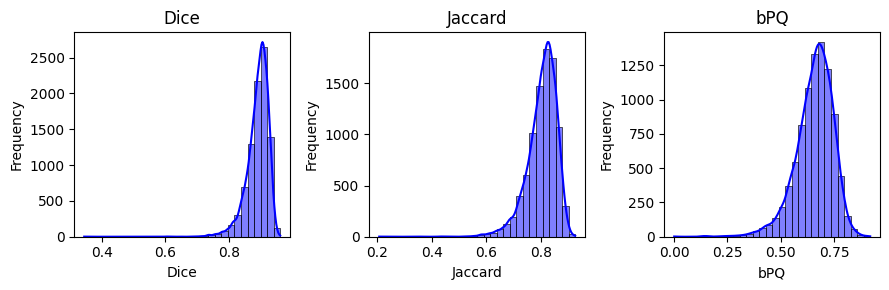

In [13]:
plot_all_metrics(df_metrics)

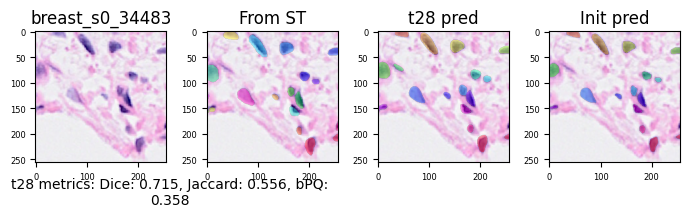

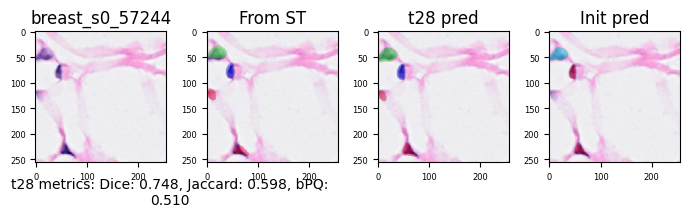

In [14]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [15]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for breast_s1

In [16]:
slide_id = "breast_s1"

In [17]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
9          breast_s1_779  0.880355  0.786280  0.800780   
10         breast_s1_780  0.898925  0.816406  0.816405   
11         breast_s1_781  0.834276  0.715673  0.715671   
27        breast_s1_1051  0.750253  0.600324  0.343971   
29        breast_s1_1053  0.928524  0.866584  0.866582   
...                  ...       ...       ...       ...   
119934  breast_s1_147352  0.877113  0.781123  0.646045   
119939  breast_s1_147357  0.919979  0.851816  0.675185   
119946  breast_s1_147364  0.892297  0.805538  0.801436   
119963  breast_s1_147626  0.925061  0.860570  0.672720   
119981  breast_s1_147898  0.885045  0.793794  0.615102   

                                    type_proba_per_nuclei  
9                         {'Stromal': 0.9652777744261188}  
10                        {'Stromal': 0.9930555532568158}  
11                         {'Stromal': 0.999999998381877}  
27      {'Epithelial': 0.16455695994231698, 'Stromal':...  
29                        {'Stromal': 0.9668874159378975}  
...                                                   ...  
119934  {'Epithelial': 0.30232557436452157, 'Stromal':...  
119939  {'Epithelial': 0.8188976345712692, 'Immune': 0...  
119946  {'Epithelial': 0.9955686839061024, 'Immune': 0...  
119963  {'Epithelial': 0.9345372439400965, 'Immune': 0...  
119981                  {'Epithelial': 0.781758955108277}  

[21497 rows x 5 columns]

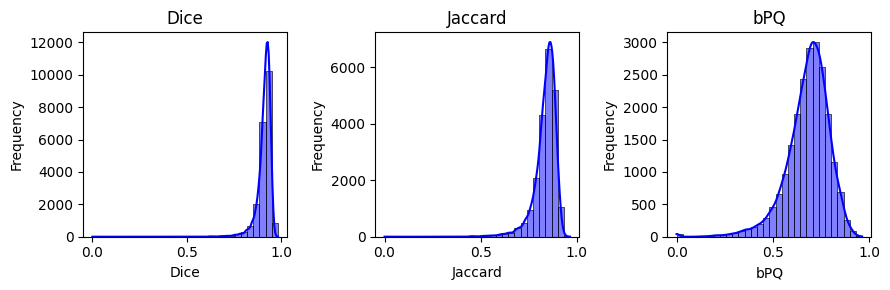

In [18]:
plot_all_metrics(df_metrics)

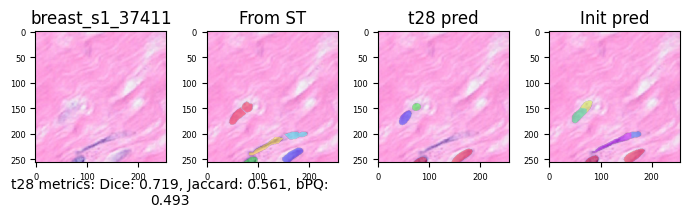

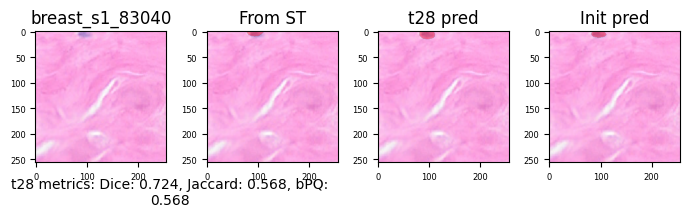

In [19]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [20]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for breast_s3

In [21]:
slide_id = "breast_s3"

In [22]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
6        breast_s3_117  0.603175  0.431818  0.253326   
21       breast_s3_345  0.869573  0.769244  0.529552   
43       breast_s3_527  0.672986  0.507143  0.432926   
45       breast_s3_532  0.730897  0.575916  0.575915   
49       breast_s3_538  0.000000  0.000000  0.000000   
...                ...       ...       ...       ...   
34562  breast_s3_49602  0.910527  0.835750  0.671570   
34610  breast_s3_49814  0.908546  0.832418  0.662202   
34614  breast_s3_49818  0.905049  0.826566  0.676954   
34624  breast_s3_49828  0.891314  0.803938  0.630932   
34630  breast_s3_49834  0.825104  0.702279  0.586777   

                                   type_proba_per_nuclei  
6                     {'Epithelial': 0.7752525232948169}  
21     {'Stromal': 0.9967741903329865, 'Epithelial': ...  
43                        {'Immune': 0.8732394325200027}  
45                        {'Immune': 0.5290322546514048}  
49                                                    {}  
...                                                  ...  
34562  {'Epithelial': 0.9779411728752163, 'Stromal': ...  
34610  {'Immune': 0.9056603730865077, 'Stromal': 0.94...  
34614                 {'Epithelial': 0.9586776819889352}  
34624                 {'Epithelial': 0.9212962920310357}  
34630                 {'Epithelial': 0.9705882067474058}  

[6567 rows x 5 columns]

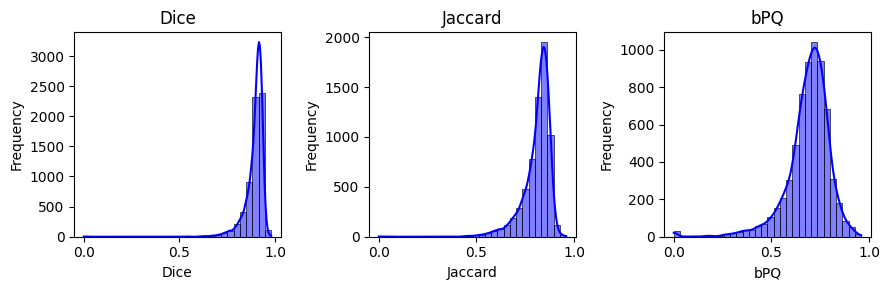

In [23]:
plot_all_metrics(df_metrics)

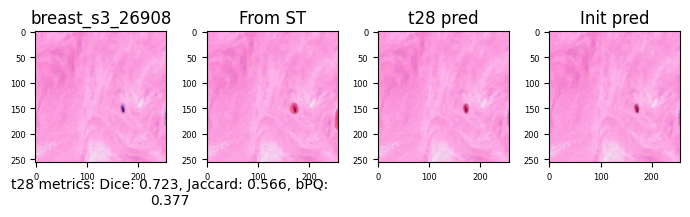

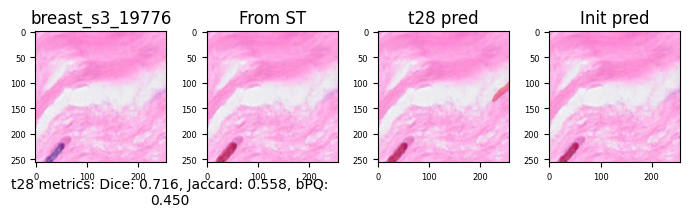

In [24]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [25]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for breast_s6

In [26]:
slide_id = "breast_s6"

In [27]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
33       breast_s6_367  0.705596  0.545113  0.573121   
34       breast_s6_370  0.806187  0.675305  0.426782   
39       breast_s6_388  0.806283  0.675439  0.000000   
42       breast_s6_415  0.885475  0.794486  0.546677   
46       breast_s6_419  0.635802  0.466063  0.000000   
...                ...       ...       ...       ...   
46892  breast_s6_55813  0.841751  0.726745  0.591903   
46894  breast_s6_55815  0.875469  0.778519  0.657708   
46898  breast_s6_55819  0.776471  0.634615  0.634614   
46914  breast_s6_55988  0.781523  0.641393  0.492505   
47010  breast_s6_56107  0.864422  0.761218  0.684184   

                                   type_proba_per_nuclei  
33                         {'Other': 0.9948979541076635}  
34                       {'Stromal': 0.9340425512041648}  
39                                                    {}  
42                       {'Stromal': 0.9937106855741467}  
46                                                    {}  
...                                                  ...  
46892  {'Stromal': 0.9180327818686733, 'Immune': 0.91...  
46894  {'Immune': 0.9892473082822677, 'Epithelial': 0...  
46898                      {'Other': 0.9752475199245172}  
46914                      {'Other': 0.9444444356995886}  
47010  {'Immune': 0.9807692280748098, 'Other': 0.8997...  

[6922 rows x 5 columns]

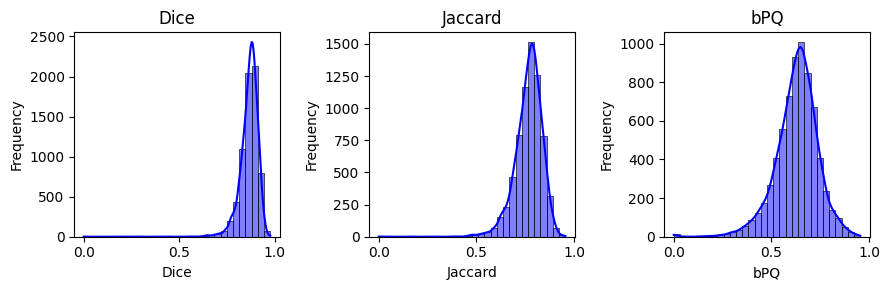

In [28]:
plot_all_metrics(df_metrics)

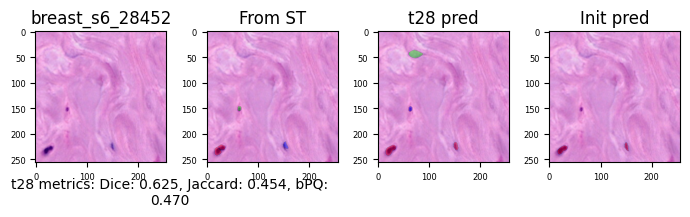

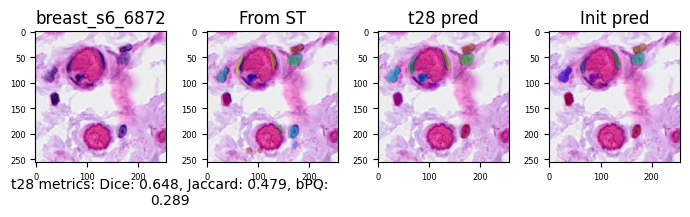

In [29]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [30]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for lung_s1

In [31]:
slide_id = "lung_s1"

In [32]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
10       lung_s1_422  0.734338  0.580200  0.494061   
16       lung_s1_431  0.855872  0.748056  0.616526   
22       lung_s1_438  0.742305  0.590211  0.499401   
28       lung_s1_444  0.723974  0.567366  0.586946   
37       lung_s1_453  0.939617  0.886111  0.756653   
...              ...       ...       ...       ...   
11244  lung_s1_16161  0.927326  0.864499  0.866028   
11263  lung_s1_16235  0.862944  0.758929  0.677290   
11269  lung_s1_16241  0.868457  0.767498  0.640357   
11285  lung_s1_16317  0.763196  0.617071  0.630332   
11291  lung_s1_16327  0.899744  0.817759  0.672971   

                                   type_proba_per_nuclei  
10     {'Epithelial': 0.994047616089144, 'Immune': 0....  
16                       {'Stromal': 0.9330543913534427}  
22                       {'Stromal': 0.9661538431810651}  
28     {'Stromal': 0.971962613794509, 'Epithelial': 0...  
37     {'Stromal': 0.9743589660311199, 'Epithelial': ...  
...                                                  ...  
11244                     {'Immune': 0.9951807204935404}  
11263  {'Immune': 0.9943661943820671, 'Stromal': 0.72...  
11269  {'Stromal': 0.9905063259794104, 'Immune': 0.99...  
11285  {'Stromal': 0.8208092438103513, 'Immune': 0.99...  
11291  {'Immune': 0.9148936072883659, 'Epithelial': 0...  

[2083 rows x 5 columns]

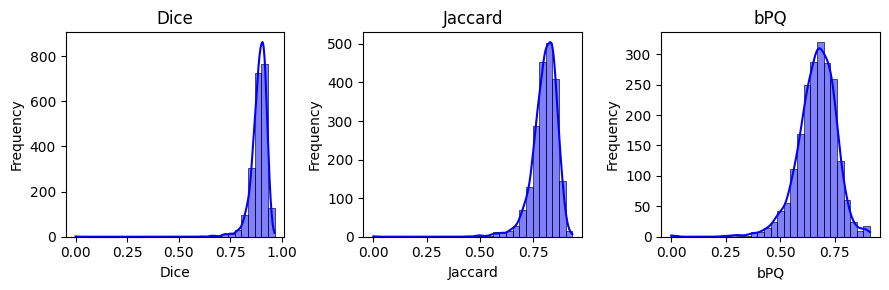

In [33]:
plot_all_metrics(df_metrics)

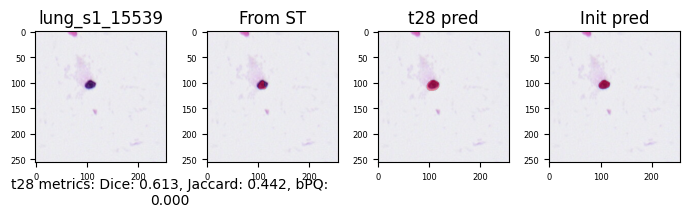

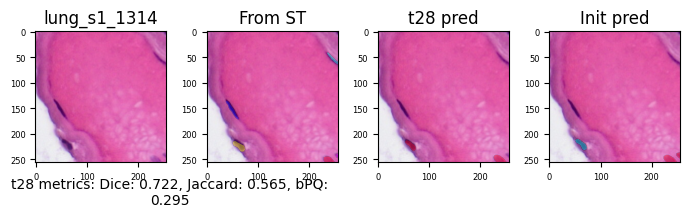

In [34]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [35]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for lung_s3

In [36]:
slide_id = "lung_s3"

In [37]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
29       lung_s3_424  0.790701  0.653850  0.502955   
32       lung_s3_427  0.900868  0.819617  0.739622   
35       lung_s3_430  0.776057  0.634063  0.557438   
39       lung_s3_434  0.824694  0.701685  0.385847   
44       lung_s3_439  0.827356  0.705548  0.661208   
...              ...       ...       ...       ...   
20796  lung_s3_30083  0.829144  0.708152  0.668239   
20797  lung_s3_30084  0.760845  0.614004  0.555562   
20907  lung_s3_30453  0.862088  0.757605  0.630622   
20908  lung_s3_30454  0.774558  0.632065  0.479593   
20919  lung_s3_30465  0.888230  0.798933  0.740655   

                                   type_proba_per_nuclei  
29     {'Epithelial': 0.9890109835768628, 'Immune': 0...  
32     {'Epithelial': 0.9977924922786038, 'Other': 0....  
35     {'Epithelial': 0.9939668159970335, 'Immune': 0...  
39                        {'Immune': 0.8612244862807164}  
44     {'Epithelial': 0.9999999964912281, 'Other': 0....  
...                                                  ...  
20796                 {'Epithelial': 0.9090909022038568}  
20797                 {'Epithelial': 0.9924098652895449}  
20907  {'Epithelial': 0.9734042527303078, 'Stromal': ...  
20908  {'Immune': 0.9921259816479633, 'Stromal': 0.34...  
20919  {'Epithelial': 0.979532160878561, 'Stromal': 0...  

[3439 rows x 5 columns]

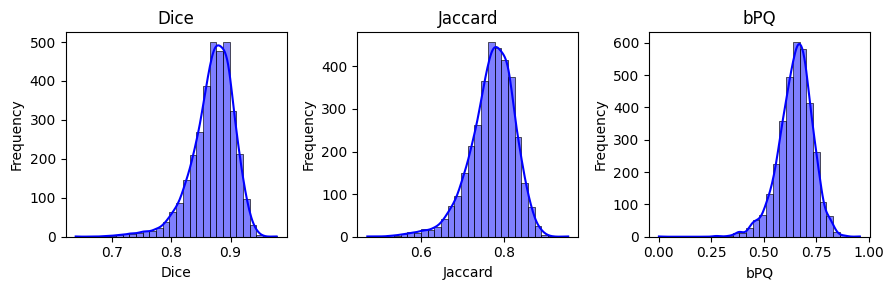

In [38]:
plot_all_metrics(df_metrics)

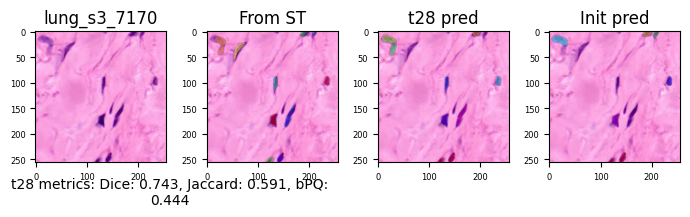

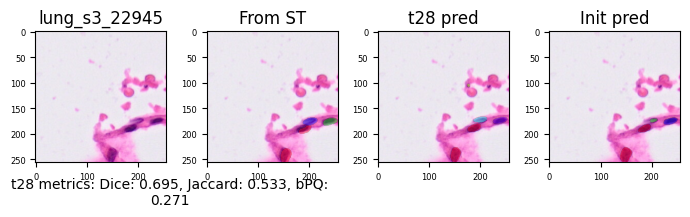

In [39]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [40]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for skin_s1

In [41]:
slide_id = "skin_s1"

In [42]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
11       skin_s1_258  0.785248  0.646427  0.539939   
32       skin_s1_453  0.846333  0.733602  0.669492   
33       skin_s1_454  0.754746  0.606098  0.465379   
38       skin_s1_459  0.834121  0.715443  0.540797   
41       skin_s1_543  0.767558  0.622794  0.448865   
...              ...       ...       ...       ...   
11632  skin_s1_17092  0.813075  0.685026  0.469669   
11633  skin_s1_17093  0.760167  0.613121  0.412412   
11636  skin_s1_17096  0.907331  0.830381  0.740565   
11637  skin_s1_17097  0.824073  0.700786  0.528056   
11643  skin_s1_17194  0.905996  0.828146  0.721024   

                                   type_proba_per_nuclei  
11     {'Epithelial': 0.9852941128171857, 'Other': 0....  
32     {'Epithelial': 0.6352941101730105, 'Melanocyte...  
33     {'Immune': 0.8381876995527906, 'Stromal': 0.95...  
38     {'Epithelial': 0.9754385930686366, 'Stromal': ...  
41                     {'Epithelial': 0.999999996742671}  
...                                                  ...  
11632                 {'Epithelial': 0.9999999978947368}  
11633  {'Other': 0.46560846314492876, 'Epithelial': 0...  
11636  {'Epithelial': 0.9846153808284024, 'Other': 0....  
11637                 {'Epithelial': 0.9952494038117592}  
11643                 {'Epithelial': 0.9979381422722925}  

[1154 rows x 5 columns]

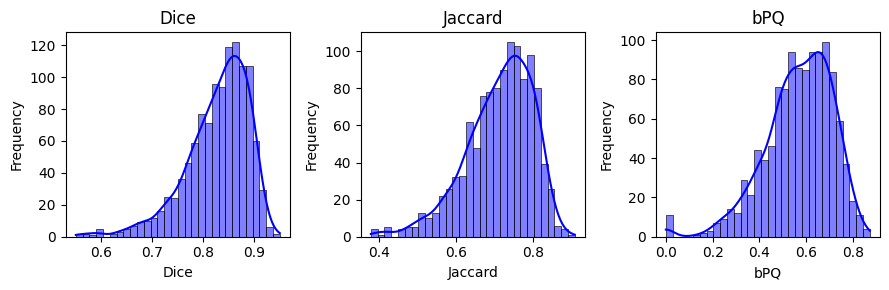

In [43]:
plot_all_metrics(df_metrics)

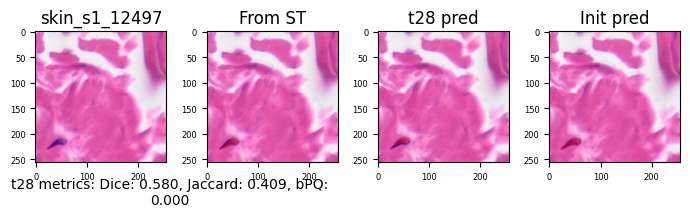

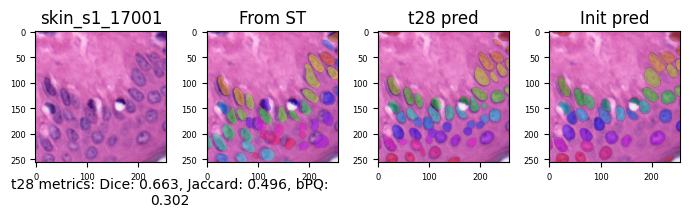

In [44]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [45]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for skin_s2

In [46]:
slide_id = "skin_s2"

In [47]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
2        skin_s2_105  0.887562  0.797854  0.446223   
5        skin_s2_220  0.930563  0.870143  0.844031   
10       skin_s2_335  0.925502  0.861334  0.593409   
15       skin_s2_450  0.853220  0.744014  0.690844   
17       skin_s2_452  0.888709  0.799709  0.720335   
...              ...       ...       ...       ...   
13179  skin_s2_25106  0.856312  0.748728  0.527546   
13191  skin_s2_25220  0.807746  0.677495  0.677494   
13205  skin_s2_25339  0.860096  0.754533  0.189920   
13206  skin_s2_25340  0.700316  0.538836  0.334000   
13218  skin_s2_25455  0.828196  0.706770  0.416371   

                                   type_proba_per_nuclei  
2                     {'Epithelial': 0.9929577394862131}  
5                     {'Epithelial': 0.9941860445849108}  
10                    {'Epithelial': 0.9994579940382341}  
15                    {'Epithelial': 0.9892183261746137}  
17                    {'Epithelial': 0.9465317905396939}  
...                                                  ...  
13179  {'Stromal': 0.9914346873845081, 'Immune': 0.43...  
13191                    {'Stromal': 0.9951456307229037}  
13205                    {'Stromal': 0.9967606086826173}  
13206                    {'Stromal': 0.9953488362833963}  
13218                    {'Stromal': 0.9999999991055455}  

[2333 rows x 5 columns]

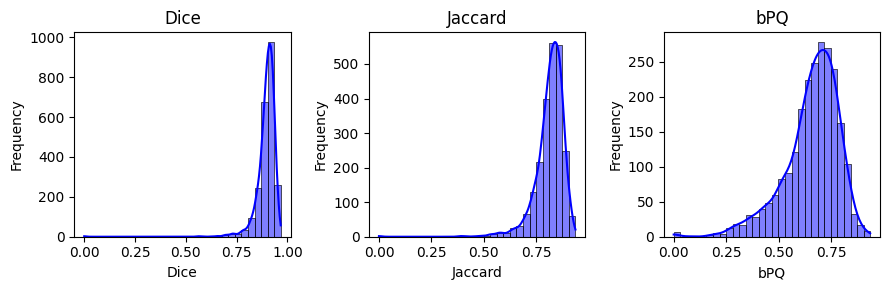

In [48]:
plot_all_metrics(df_metrics)

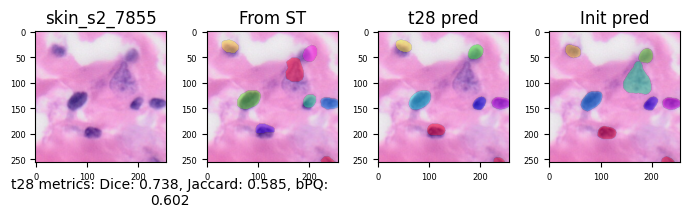

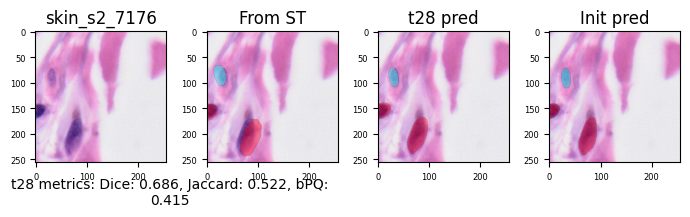

In [49]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [50]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for skin_s3

In [51]:
slide_id = "skin_s3"

In [52]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
12      skin_s3_242  0.624390  0.453901  0.000000   
44      skin_s3_453  0.920569  0.852828  0.745672   
51      skin_s3_460  0.883963  0.792056  0.637985   
70      skin_s3_563  0.891637  0.804462  0.708651   
83      skin_s3_660  0.854746  0.746338  0.644350   
...             ...       ...       ...       ...   
5954  skin_s3_11829  0.834446  0.715922  0.496903   
5956  skin_s3_11831  0.873392  0.775240  0.643168   
5960  skin_s3_11932  0.884787  0.793380  0.658337   
5971  skin_s3_12041  0.791457  0.654885  0.501309   
5972  skin_s3_12042  0.709511  0.549800  0.267683   

                                  type_proba_per_nuclei  
12                   {'Melanocyte': 0.9082568790674186}  
44                   {'Epithelial': 0.9999999924812031}  
51                   {'Melanocyte': 0.7657004812422694}  
70                      {'Stromal': 0.9970760204763859}  
83    {'Epithelial': 0.9882352912110727, 'Immune': 0...  
...                                                 ...  
5954  {'Epithelial': 0.9837662305721876, 'Immune': 0...  
5956  {'Immune': 0.9782608653119093, 'Epithelial': 0...  
5960  {'Epithelial': 0.9956709913607317, 'Other': 0....  
5971  {'Epithelial': 0.9166666581790125, 'Other': 0....  
5972  {'Epithelial': 0.9999999957805907, 'Stromal': ...  

[944 rows x 5 columns]

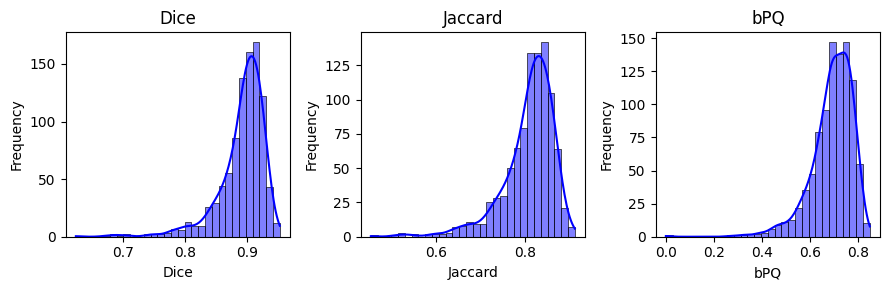

In [53]:
plot_all_metrics(df_metrics)

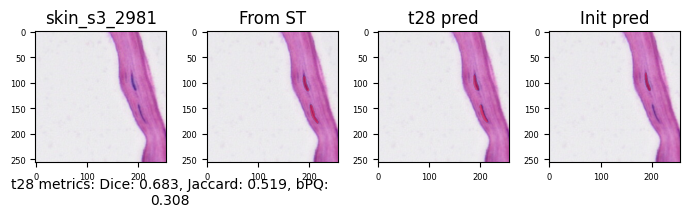

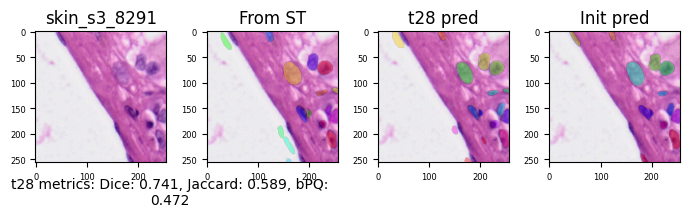

In [54]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [55]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for skin_s4

In [56]:
slide_id = "skin_s4"

In [57]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
23      skin_s4_619  0.729363  0.574013  0.559798   
26      skin_s4_622  0.895575  0.810896  0.674040   
42      skin_s4_722  0.852411  0.742784  0.568221   
63      skin_s4_816  0.875255  0.778181  0.688417   
66      skin_s4_819  0.885563  0.794628  0.675909   
...             ...       ...       ...       ...   
5904  skin_s4_17039  0.783155  0.643595  0.547056   
5910  skin_s4_17045  0.831562  0.711688  0.593934   
5914  skin_s4_17049  0.816115  0.689354  0.642428   
5933  skin_s4_17128  0.701772  0.540561  0.515329   
5949  skin_s4_17144  0.775022  0.632682  0.426246   

                                  type_proba_per_nuclei  
23    {'Stromal': 0.9734747984788467, 'Other': 0.947...  
26                   {'Epithelial': 0.9999999949238579}  
42                    {'Epithelial': 0.983240217970725}  
63                    {'Epithelial': 0.997518607946604}  
66                   {'Epithelial': 0.9889867819625842}  
...                                                 ...  
5904  {'Stromal': 0.9957264914712544, 'Immune': 0.98...  
5910  {'Melanocyte': 0.9999999976958526, 'Stromal': ...  
5914  {'Immune': 0.9837586984135529, 'Melanocyte': 0...  
5933  {'Melanocyte': 0.9999999642857155, 'Immune': 0...  
5949  {'Immune': 0.942105258199446, 'Stromal': 0.871...  

[1042 rows x 5 columns]

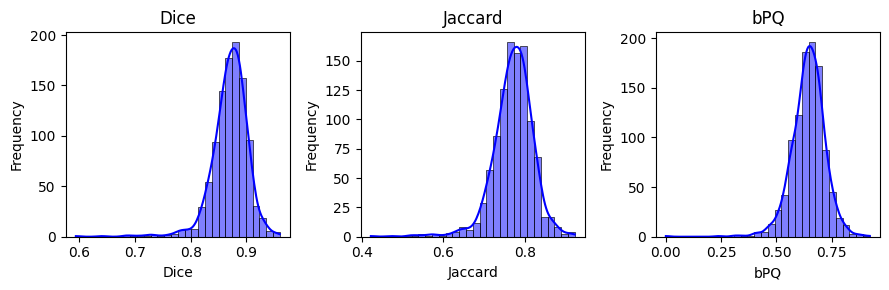

In [58]:
plot_all_metrics(df_metrics)

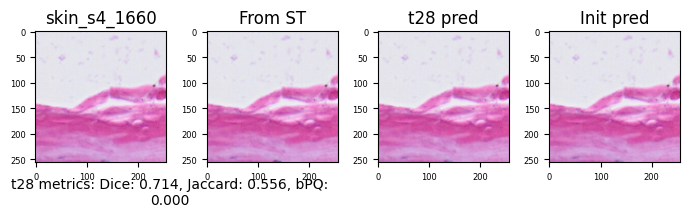

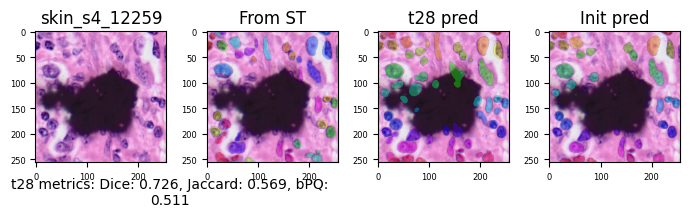

In [59]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [60]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for pancreatic_s0

In [61]:
slide_id = "pancreatic_s0"

In [62]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
28       pancreatic_s0_366  0.715397  0.556901  0.556900   
29       pancreatic_s0_367  0.832007  0.712339  0.696642   
35       pancreatic_s0_378  0.818904  0.693343  0.316339   
39       pancreatic_s0_382  0.821109  0.696510  0.607455   
41       pancreatic_s0_433  0.658333  0.490683  0.000000   
...                    ...       ...       ...       ...   
26062  pancreatic_s0_39122  0.806208  0.675334  0.675332   
26072  pancreatic_s0_39147  0.815753  0.688837  0.688836   
26076  pancreatic_s0_39152  0.801186  0.668315  0.529053   
26111  pancreatic_s0_39346  0.835289  0.717164  0.717162   
26129  pancreatic_s0_39686  0.810216  0.680978  0.349018   

                                   type_proba_per_nuclei  
28                        {'Immune': 0.9983766217558822}  
29                       {'Stromal': 0.9920477127315629}  
35                       {'Stromal': 0.9449339186234936}  
39     {'Stromal': 0.9903677749646516, 'Background': ...  
41                       {'Stromal': 0.9758064437434965}  
...                                                  ...  
26062                    {'Stromal': 0.9885563371579609}  
26072                     {'Stromal': 0.996822514300126}  
26076  {'Background': 0.9999999983164983, 'Stromal': ...  
26111                     {'Immune': 0.9519852253444272}  
26129                     {'Immune': 0.4636510497062592}  

[4013 rows x 5 columns]

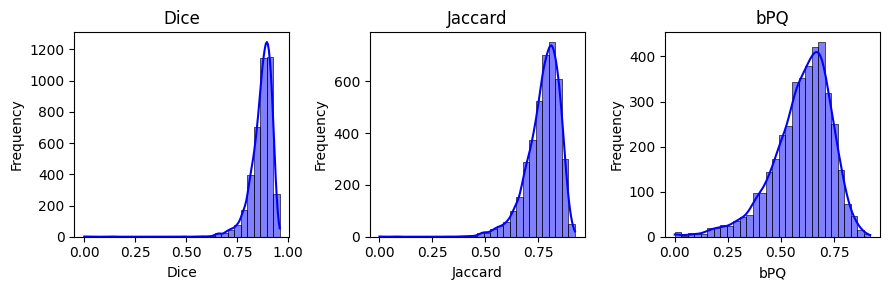

In [63]:
plot_all_metrics(df_metrics)

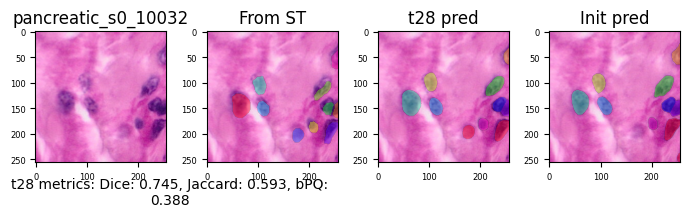

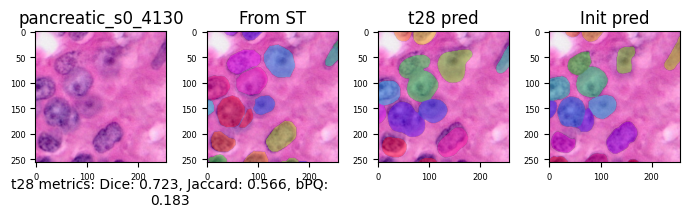

In [64]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [65]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for pancreatic_s1

In [66]:
slide_id = "pancreatic_s1"

In [67]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
16       pancreatic_s1_416  0.853468  0.744391  0.675174   
17       pancreatic_s1_417  0.819639  0.694397  0.703957   
31       pancreatic_s1_512  0.819322  0.693942  0.499268   
32       pancreatic_s1_513  0.821455  0.697007  0.546402   
51       pancreatic_s1_608  0.944773  0.895327  0.895325   
...                    ...       ...       ...       ...   
12743  pancreatic_s1_20420  0.862126  0.757663  0.513204   
12765  pancreatic_s1_20510  0.758488  0.610939  0.453626   
12767  pancreatic_s1_20512  0.784397  0.645273  0.575373   
12780  pancreatic_s1_20601  0.825109  0.702286  0.456782   
12788  pancreatic_s1_20694  0.880311  0.786210  0.512777   

                                   type_proba_per_nuclei  
16                      {'Stromal': 0.13953488047593302}  
17                       {'Stromal': 0.9982110894486385}  
31     {'Immune': 0.9965753390528241, 'Stromal': 0.87...  
32     {'Immune': 0.9999999969325154, 'Stromal': 0.97...  
51                            {'Immune': 0.985999998028}  
...                                                  ...  
12743  {'Epithelial': 0.8874172126661112, 'Other': 0....  
12765  {'Stromal': 0.7519685009765019, 'Other': 0.929...  
12767  {'Epithelial': 0.9700374519724876, 'Other': 0....  
12780  {'Other': 0.7307692237426037, 'Epithelial': 0....  
12788  {'Immune': 0.9811853236301172, 'Other': 0.5974...  

[2202 rows x 5 columns]

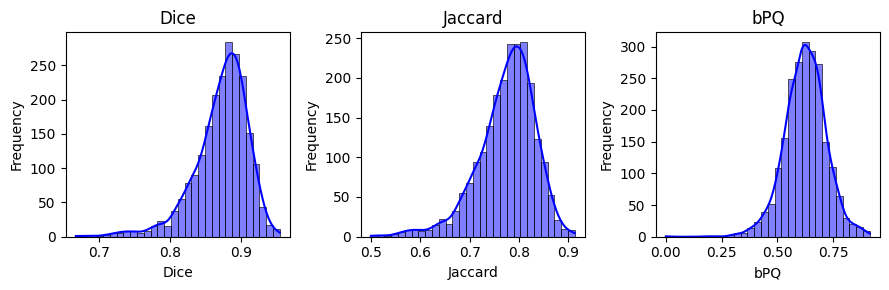

In [68]:
plot_all_metrics(df_metrics)

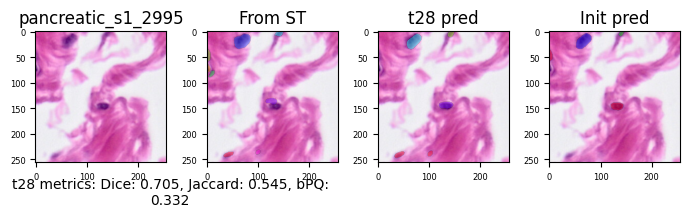

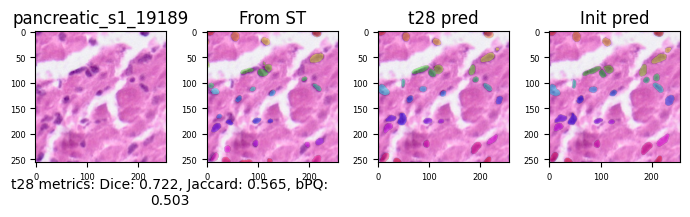

In [69]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [70]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for pancreatic_s2

In [71]:
slide_id = "pancreatic_s2"

In [72]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
47      pancreatic_s2_484  0.884749  0.793319  0.599571   
51      pancreatic_s2_488  0.772503  0.629332  0.482627   
53      pancreatic_s2_490  0.879625  0.785116  0.673000   
54      pancreatic_s2_491  0.873310  0.775111  0.689451   
67      pancreatic_s2_561  0.812657  0.684434  0.566879   
...                   ...       ...       ...       ...   
6985  pancreatic_s2_10796  0.878001  0.782533  0.707174   
6986  pancreatic_s2_10797  0.868475  0.767526  0.680684   
6992  pancreatic_s2_10803  0.859659  0.753861  0.646458   
6999  pancreatic_s2_10810  0.763017  0.616837  0.513986   
7009  pancreatic_s2_10898  0.771743  0.628324  0.474620   

                                  type_proba_per_nuclei  
47    {'Epithelial': 0.938223934601452, 'Stromal': 0...  
51    {'Stromal': 0.9616519145673985, 'Immune': 0.88...  
53    {'Epithelial': 0.9928762235148029, 'Stromal': ...  
54    {'Immune': 0.9972144819019095, 'Stromal': 0.99...  
67    {'Stromal': 0.9710144899390885, 'Other': 0.698...  
...                                                 ...  
6985  {'Epithelial': 0.9999999977324263, 'Stromal': ...  
6986  {'Epithelial': 0.995708152369725, 'Immune': 0....  
6992  {'Epithelial': 0.931654672907717, 'Immune': 0....  
6999  {'Immune': 0.8815789415685596, 'Stromal': 0.97...  
7009  {'Epithelial': 0.9925925889163237, 'Immune': 0...  

[1228 rows x 5 columns]

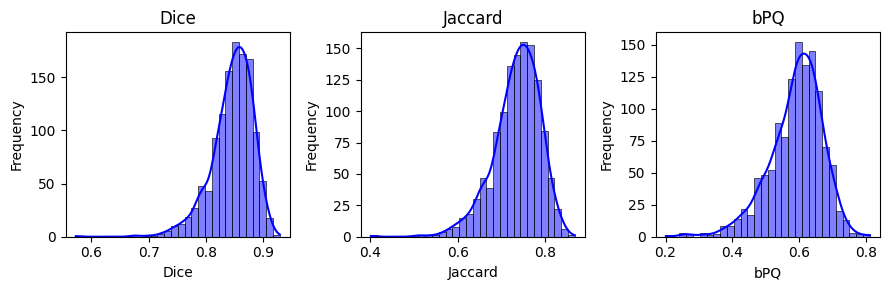

In [73]:
plot_all_metrics(df_metrics)

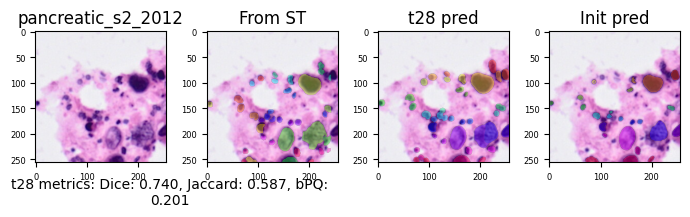

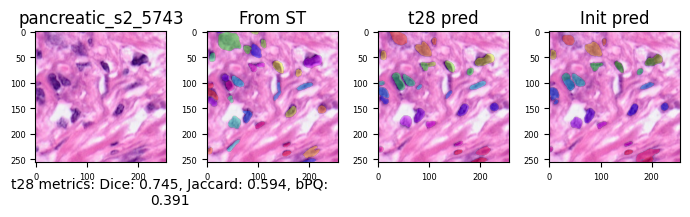

In [74]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [75]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for heart_s0

In [76]:
slide_id = "heart_s0"

In [77]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
6      heart_s0_364  0.926148  0.862454  0.743289   
27     heart_s0_479  0.808114  0.678013  0.508185   
32     heart_s0_484  0.856222  0.748591  0.736983   
43     heart_s0_495  0.763100  0.616945  0.749142   
45     heart_s0_497  0.928803  0.867069  0.840498   
...             ...       ...       ...       ...   
5432  heart_s0_6591  0.806686  0.676005  0.521631   
5453  heart_s0_6612  0.661005  0.493657  0.456347   
5454  heart_s0_6613  0.803528  0.671582  0.551109   
5461  heart_s0_6661  0.904664  0.825923  0.716801   
5464  heart_s0_6664  0.895369  0.810559  0.542608   

                                  type_proba_per_nuclei  
6     {'Other': 0.9886201977402274, 'Stromal': 0.991...  
27    {'Stromal': 0.9716981086240656, 'Immune': 0.96...  
32                      {'Stromal': 0.9868421020169668}  
43    {'Other': 0.980440095402347, 'Stromal': 0.9888...  
45                      {'Stromal': 0.9791183271946211}  
...                                                 ...  
5432                     {'Stromal': 0.947368416066482}  
5453                    {'Stromal': 0.9348837165819363}  
5454                    {'Stromal': 0.9830508391266878}  
5461                    {'Stromal': 0.9846153824513948}  
5464                    {'Stromal': 0.9941520448457075}  

[963 rows x 5 columns]

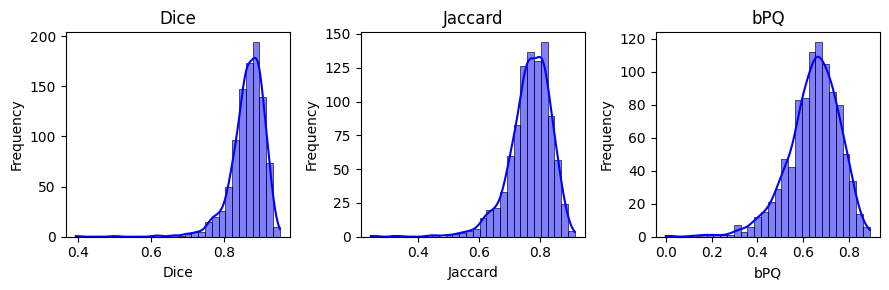

In [78]:
plot_all_metrics(df_metrics)

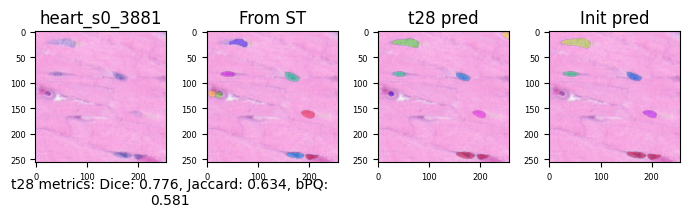

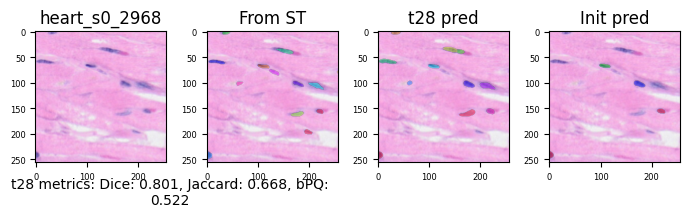

In [79]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.5, 
            high_threshold=0.8, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [80]:
# plot_patch_seg(patch_id="heart_s0_500", 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for colon_s1

In [81]:
slide_id = "colon_s1"

In [82]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
114     colon_s1_5394  0.779367  0.638493  0.311333   
118     colon_s1_5398  0.648305  0.479623  0.077867   
124     colon_s1_5404  0.801709  0.669043  0.516073   
126     colon_s1_5406  0.847384  0.735184  0.458676   
129     colon_s1_5409  0.862038  0.757527  0.632326   
...               ...       ...       ...       ...   
18327  colon_s1_27905  0.883002  0.790514  0.574571   
18328  colon_s1_27906  0.911570  0.837509  0.590960   
18331  colon_s1_27909  0.872798  0.774305  0.532882   
18391  colon_s1_28044  0.862805  0.758713  0.480523   
18454  colon_s1_28186  0.882556  0.789798  0.545698   

                                   type_proba_per_nuclei  
114    {'Epithelial': 0.9638554100740312, 'Immune': 0...  
118    {'Immune': 0.8151041645439996, 'Stromal': 0.88...  
124    {'Epithelial': 0.9582132551034391, 'Immune': 0...  
126    {'Immune': 0.9886731375587814, 'Epithelial': 0...  
129    {'Epithelial': 0.9946808497411159, 'Stromal': ...  
...                                                  ...  
18327                 {'Epithelial': 0.9491525262855505}  
18328                 {'Epithelial': 0.9999999952380952}  
18331  {'Epithelial': 0.9811320662157352, 'Stromal': ...  
18391  {'Epithelial': 0.8437499736328133, 'Stromal': ...  
18454                 {'Epithelial': 0.9999999944444445}  

[2186 rows x 5 columns]

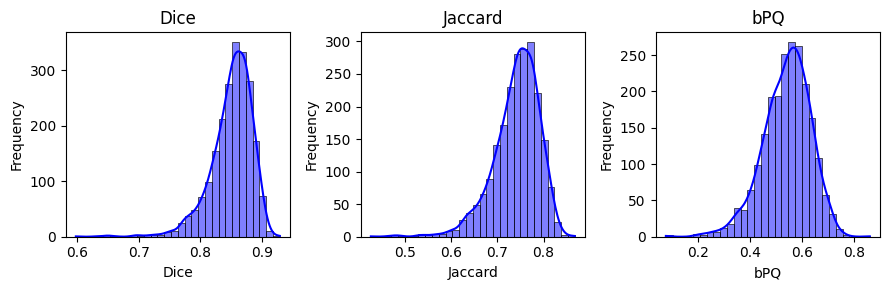

In [83]:
plot_all_metrics(df_metrics)

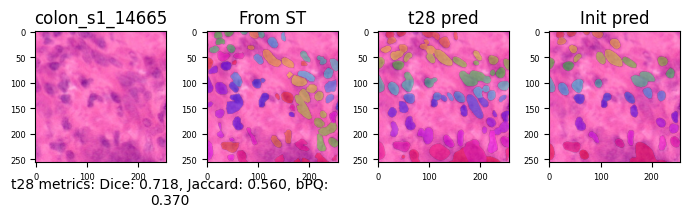

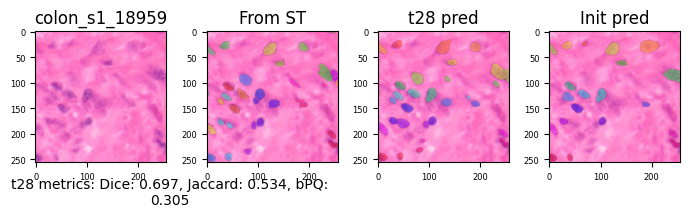

In [84]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [85]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for colon_s2

In [86]:
slide_id = "colon_s1"

In [87]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
114     colon_s1_5394  0.779367  0.638493  0.311333   
118     colon_s1_5398  0.648305  0.479623  0.077867   
124     colon_s1_5404  0.801709  0.669043  0.516073   
126     colon_s1_5406  0.847384  0.735184  0.458676   
129     colon_s1_5409  0.862038  0.757527  0.632326   
...               ...       ...       ...       ...   
18327  colon_s1_27905  0.883002  0.790514  0.574571   
18328  colon_s1_27906  0.911570  0.837509  0.590960   
18331  colon_s1_27909  0.872798  0.774305  0.532882   
18391  colon_s1_28044  0.862805  0.758713  0.480523   
18454  colon_s1_28186  0.882556  0.789798  0.545698   

                                   type_proba_per_nuclei  
114    {'Epithelial': 0.9638554100740312, 'Immune': 0...  
118    {'Immune': 0.8151041645439996, 'Stromal': 0.88...  
124    {'Epithelial': 0.9582132551034391, 'Immune': 0...  
126    {'Immune': 0.9886731375587814, 'Epithelial': 0...  
129    {'Epithelial': 0.9946808497411159, 'Stromal': ...  
...                                                  ...  
18327                 {'Epithelial': 0.9491525262855505}  
18328                 {'Epithelial': 0.9999999952380952}  
18331  {'Epithelial': 0.9811320662157352, 'Stromal': ...  
18391  {'Epithelial': 0.8437499736328133, 'Stromal': ...  
18454                 {'Epithelial': 0.9999999944444445}  

[2186 rows x 5 columns]

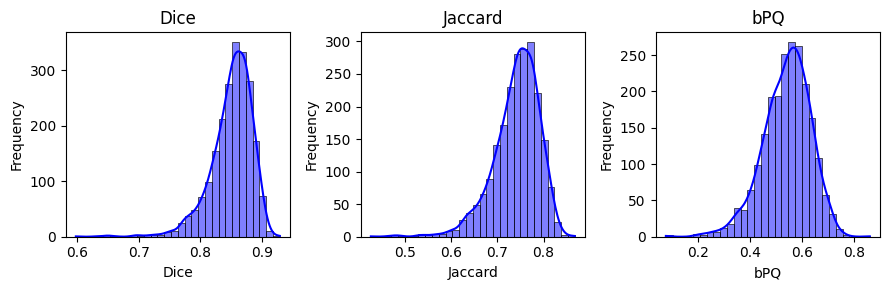

In [88]:
plot_all_metrics(df_metrics)

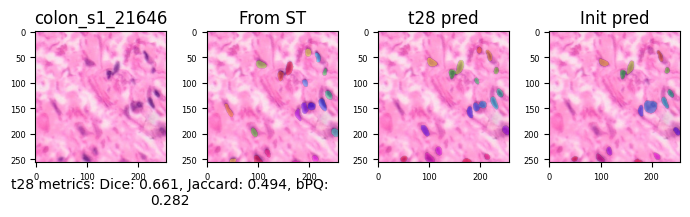

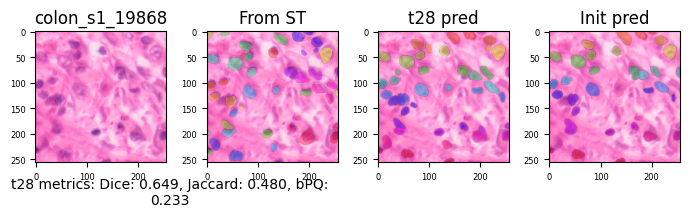

In [89]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [90]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for kidney_s0

In [91]:
slide_id = "kidney_s0"

In [92]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
5       kidney_s0_192  0.804143  0.672441  0.615362   
6       kidney_s0_193  0.783720  0.644358  0.572501   
7       kidney_s0_194  0.741426  0.589101  0.616119   
10      kidney_s0_197  0.705873  0.545443  0.516835   
16      kidney_s0_203  0.703631  0.542771  0.489372   
...               ...       ...       ...       ...   
6925  kidney_s0_10561  0.938413  0.883972  0.747824   
6930  kidney_s0_10612  0.920296  0.852359  0.759412   
6932  kidney_s0_10614  0.937303  0.882005  0.875248   
6937  kidney_s0_10619  0.897663  0.814327  0.588833   
6943  kidney_s0_10672  0.923807  0.858403  0.853271   

                                  type_proba_per_nuclei  
5     {'Epithelial': 0.9999999959183674, 'Stromal': ...  
6     {'Epithelial': 0.9794050320837413, 'Stromal': ...  
7     {'Stromal': 0.9999999970760234, 'Epithelial': ...  
10    {'Stromal': 0.9770642157015403, 'Epithelial': ...  
16    {'Epithelial': 0.9999999948717949, 'Stromal': ...  
...                                                 ...  
6925  {'Stromal': 0.9263456064409473, 'Epithelial': ...  
6930  {'Epithelial': 0.9857142828979591, 'Stromal': ...  
6932  {'Immune': 0.9919678675021371, 'Epithelial': 0...  
6937  {'Immune': 0.6746987924710892, 'Stromal': 0.87...  
6943                 {'Epithelial': 0.9979716004097939}  

[1314 rows x 5 columns]

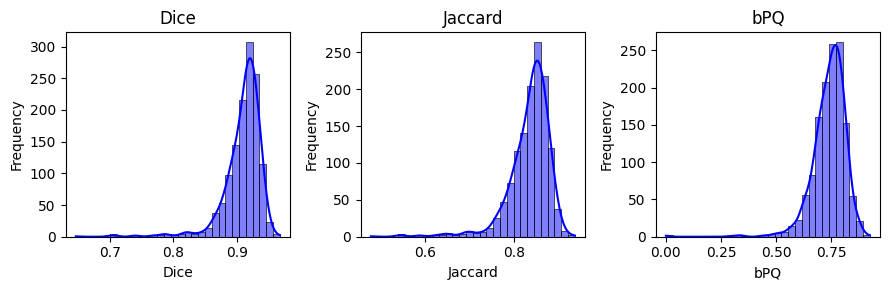

In [93]:
plot_all_metrics(df_metrics)

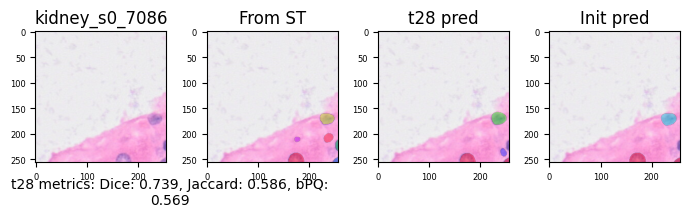

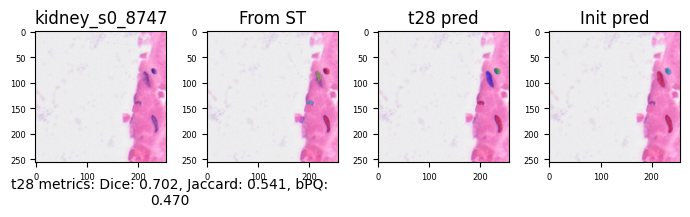

In [94]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [95]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for kidney_s1

In [96]:
slide_id = "kidney_s1"

In [97]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
9      kidney_s1_131  0.859945  0.754302  0.743518   
14     kidney_s1_146  0.882522  0.789745  0.718979   
22     kidney_s1_154  0.843878  0.729921  0.516533   
28     kidney_s1_160  0.917241  0.847134  0.847132   
29     kidney_s1_161  0.760618  0.613707  0.447780   
...              ...       ...       ...       ...   
4683  kidney_s1_6260  0.912816  0.839615  0.439187   
4691  kidney_s1_6283  0.908273  0.831960  0.313804   
4715  kidney_s1_6320  0.936458  0.880508  0.859495   
4718  kidney_s1_6323  0.759648  0.612445  0.610113   
4749  kidney_s1_6365  0.748436  0.598000  0.535841   

                                  type_proba_per_nuclei  
9     {'Immune': 0.8629629597668038, 'Stromal': 0.92...  
14    {'Immune': 0.9778672012517763, 'Stromal': 0.94...  
22    {'Stromal': 0.9934853387834354, 'Immune': 0.98...  
28                      {'Stromal': 0.9950495024875012}  
29                      {'Stromal': 0.9999999958677687}  
...                                                 ...  
4683  {'Immune': 0.7574750805399499, 'Epithelial': 0...  
4691                 {'Epithelial': 0.8776223745537679}  
4715                 {'Epithelial': 0.9821958427828017}  
4718                     {'Immune': 0.9458544823251194}  
4749                    {'Stromal': 0.9768115913715606}  

[887 rows x 5 columns]

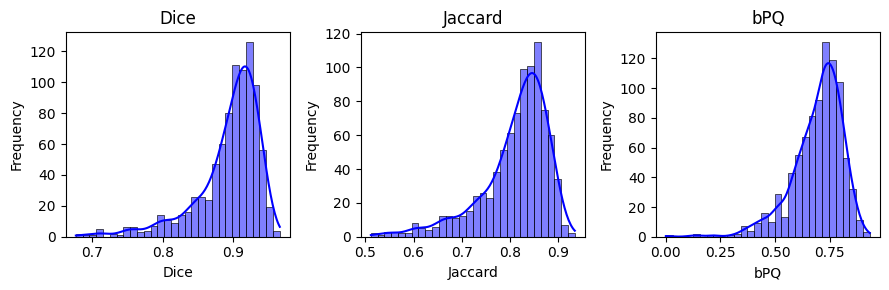

In [98]:
plot_all_metrics(df_metrics)

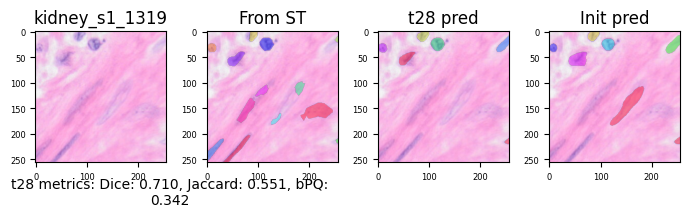

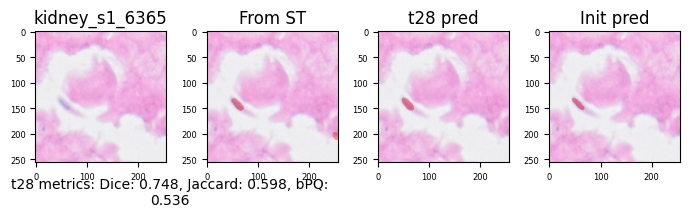

In [99]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [100]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for liver_s0

In [101]:
slide_id = "liver_s0"

In [102]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
30       liver_s0_367  0.757776  0.610016  0.505759   
62       liver_s0_507  0.848837  0.737373  0.585078   
65       liver_s0_510  0.867855  0.766557  0.661852   
68       liver_s0_513  0.808447  0.678482  0.558642   
71       liver_s0_516  0.866500  0.764446  0.586809   
...               ...       ...       ...       ...   
20817  liver_s0_30973  0.787279  0.649184  0.508423   
20823  liver_s0_30979  0.951570  0.907613  0.789852   
20825  liver_s0_30981  0.872102  0.773210  0.759016   
20827  liver_s0_30983  0.916348  0.845610  0.792413   
20860  liver_s0_31126  0.900357  0.818773  0.691958   

                                   type_proba_per_nuclei  
30     {'Immune': 0.9999999968454258, 'Epithelial': 0...  
62     {'Epithelial': 0.9292682904164188, 'Stromal': ...  
65     {'Epithelial': 0.9738095214909297, 'Immune': 0...  
68     {'Epithelial': 0.9760478983470185, 'Stromal': ...  
71     {'Epithelial': 0.9226006163386978, 'Stromal': ...  
...                                                  ...  
20817  {'Epithelial': 0.9672619018831491, 'Stromal': ...  
20823  {'Epithelial': 0.9936708797868932, 'Immune': 0...  
20825  {'Epithelial': 0.9999999955156951, 'Stromal': ...  
20827  {'Epithelial': 0.9965753390528241, 'Stromal': ...  
20860  {'Epithelial': 0.8472222104552471, 'Stromal': ...  

[3818 rows x 5 columns]

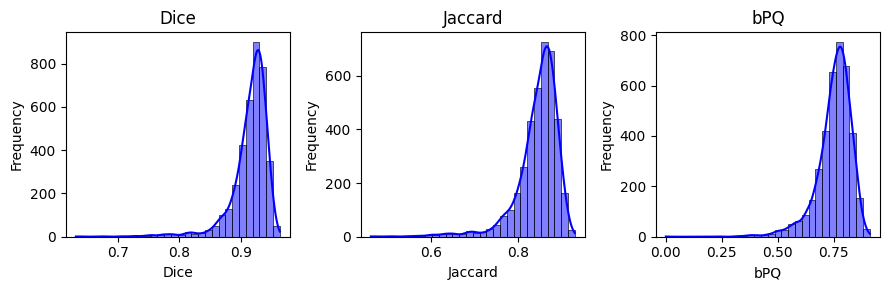

In [103]:
plot_all_metrics(df_metrics)

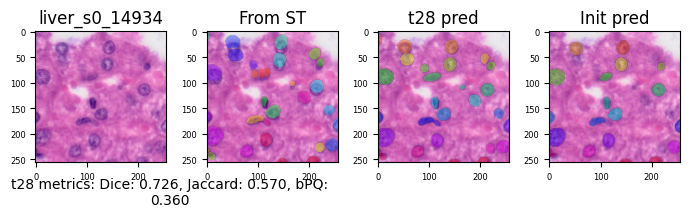

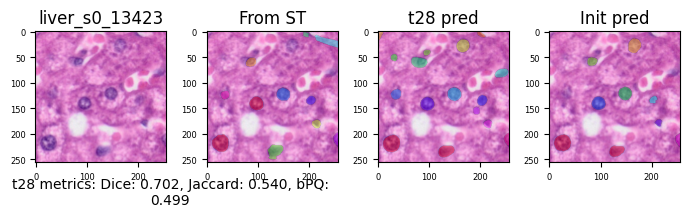

In [104]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [105]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for liver_s1

In [106]:
slide_id = "liver_s1"

In [107]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
6       liver_s1_251  0.921243  0.853985  0.692941   
10      liver_s1_255  0.924463  0.859536  0.665755   
18      liver_s1_292  0.871886  0.772871  0.743109   
20      liver_s1_323  0.895829  0.811314  0.599915   
27      liver_s1_330  0.802773  0.670527  0.500853   
...              ...       ...       ...       ...   
9616  liver_s1_13743  0.907821  0.831201  0.780198   
9625  liver_s1_13822  0.913377  0.840565  0.746943   
9626  liver_s1_13823  0.858278  0.751740  0.722255   
9638  liver_s1_13906  0.714953  0.556364  0.556363   
9640  liver_s1_13908  0.731369  0.576503  0.423704   

                                  type_proba_per_nuclei  
6                    {'Epithelial': 0.9931972721551207}  
10                   {'Epithelial': 0.9919137439571059}  
18    {'Stromal': 0.9797468329626663, 'Epithelial': ...  
20                   {'Epithelial': 0.9562043725824498}  
27    {'Epithelial': 0.6874999570312527, 'Stromal': ...  
...                                                 ...  
9616  {'Immune': 0.9556961995072906, 'Background': 0...  
9625  {'Stromal': 0.9951456262371572, 'Immune': 0.83...  
9626  {'Stromal': 0.9473684110803325, 'Immune': 0.89...  
9638                    {'Stromal': 0.9667896643291894}  
9640                    {'Stromal': 0.9871244592827276}  

[1938 rows x 5 columns]

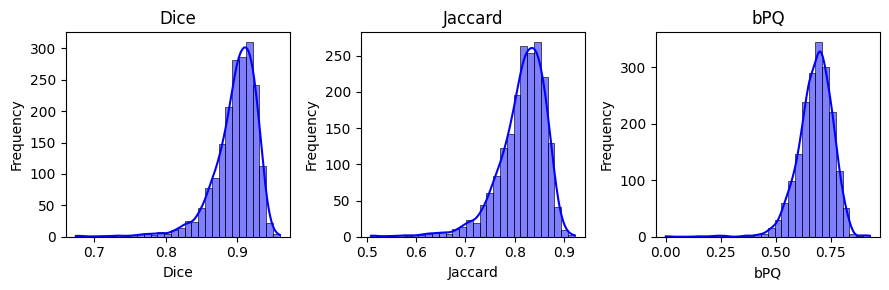

In [108]:
plot_all_metrics(df_metrics)

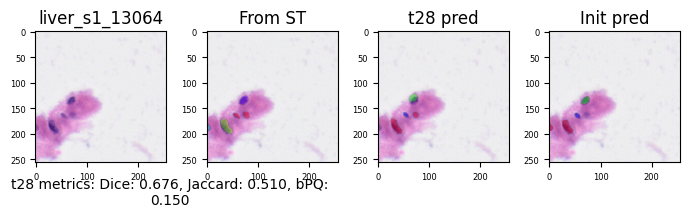

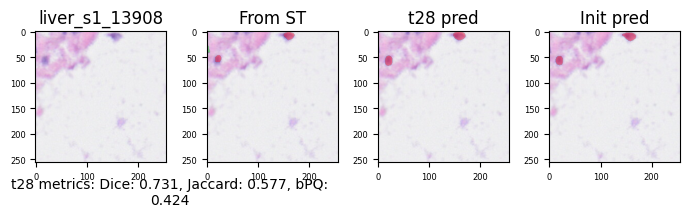

In [109]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [110]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for tonsil_s0

In [111]:
slide_id = "tonsil_s0"

In [112]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
19       tonsil_s0_683  0.850231  0.739479  0.579994   
21       tonsil_s0_685  0.877172  0.781217  0.635441   
28       tonsil_s0_848  0.814725  0.687372  0.478677   
31       tonsil_s0_851  0.832869  0.713604  0.484251   
44      tonsil_s0_1179  0.857590  0.750685  0.551397   
...                ...       ...       ...       ...   
23359  tonsil_s0_34870  0.929602  0.868463  0.761220   
23386  tonsil_s0_35196  0.907759  0.831098  0.739401   
23387  tonsil_s0_35197  0.911657  0.837655  0.617667   
23391  tonsil_s0_35201  0.817708  0.691630  0.594912   
23392  tonsil_s0_35202  0.745694  0.594507  0.410693   

                                   type_proba_per_nuclei  
19     {'Epithelial': 0.9999999906542058, 'Immune': 0...  
21     {'Immune': 0.9679487117439185, 'Epithelial': 0...  
28     {'Immune': 0.9741935452445369, 'Epithelial': 0...  
31     {'Immune': 0.8457446763524219, 'Epithelial': 0...  
44     {'Immune': 0.9742489228573008, 'Epithelial': 0...  
...                                                  ...  
23359                 {'Epithelial': 0.8999999910000002}  
23386                 {'Epithelial': 0.9943289206156353}  
23387                 {'Epithelial': 0.9977272704597108}  
23391                 {'Epithelial': 0.9916666584027779}  
23392                 {'Epithelial': 0.9955357120635364}  

[4405 rows x 5 columns]

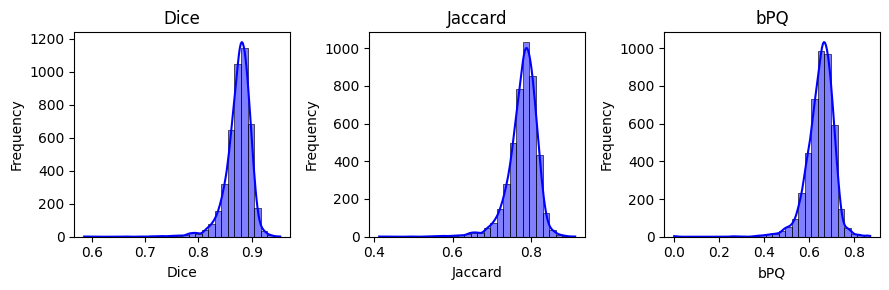

In [113]:
plot_all_metrics(df_metrics)

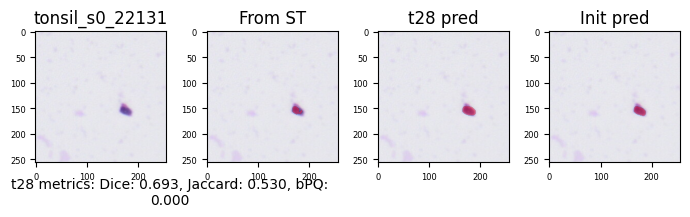

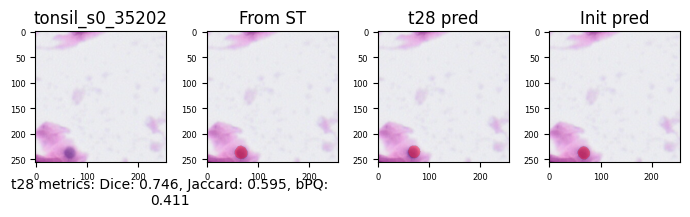

In [114]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [115]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for tonsil_s1

In [116]:
slide_id = "tonsil_s1"

In [117]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
75      tonsil_s1_2001  0.777258  0.635668  0.188815   
81      tonsil_s1_2231  0.600000  0.428571  0.000000   
113     tonsil_s1_2500  0.751567  0.602008  0.308520   
166     tonsil_s1_3227  0.800160  0.666888  0.431569   
175     tonsil_s1_3236  0.810811  0.681818  0.512015   
...                ...       ...       ...       ...   
21313  tonsil_s1_42616  0.859358  0.753398  0.606736   
21314  tonsil_s1_42617  0.862600  0.758396  0.559638   
21328  tonsil_s1_42859  0.806414  0.675623  0.495361   
21337  tonsil_s1_42868  0.889173  0.800461  0.663808   
21339  tonsil_s1_42870  0.866199  0.763978  0.604104   

                                   type_proba_per_nuclei  
75     {'Stromal': 0.9710982640248589, 'Other': 0.993...  
81                                                    {}  
113    {'Stromal': 0.9321428538137755, 'Other': 0.956...  
166    {'Stromal': 0.8991596563095827, 'Other': 0.853...  
175    {'Other': 0.7826086871455578, 'Stromal': 0.827...  
...                                                  ...  
21313  {'Epithelial': 0.9900332193022152, 'Immune': 0...  
21314  {'Immune': 0.9759615337694157, 'Epithelial': 0...  
21328                 {'Epithelial': 0.7772020685119064}  
21337                 {'Epithelial': 0.9234234192638585}  
21339                 {'Epithelial': 0.8548386958896985}  

[3430 rows x 5 columns]

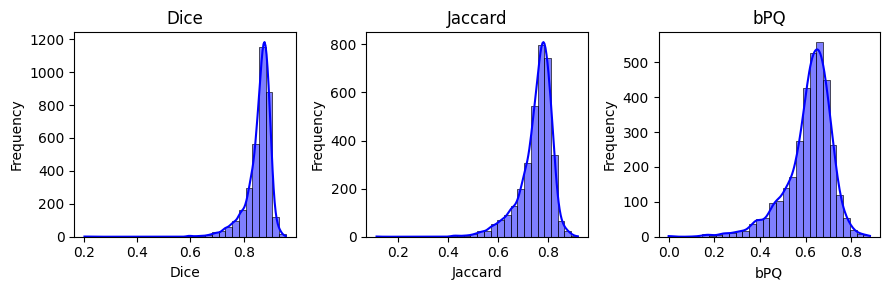

In [118]:
plot_all_metrics(df_metrics)

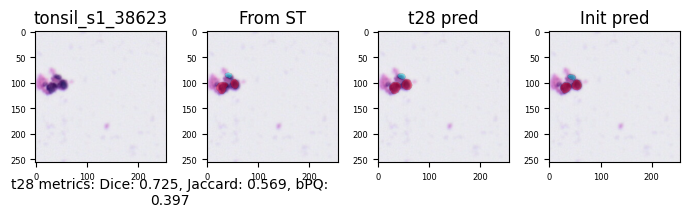

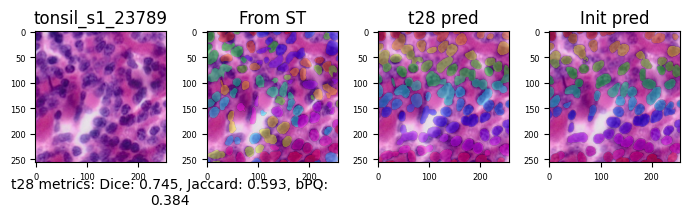

In [119]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [120]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for lymph_node_s0

In [121]:
slide_id = "lymph_node_s0"

In [122]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
4        lymph_node_s0_237  0.818329  0.692519  0.574207   
14       lymph_node_s0_393  0.842604  0.728016  0.717651   
18       lymph_node_s0_534  0.853170  0.743938  0.743206   
19       lymph_node_s0_535  0.873722  0.775761  0.616617   
22       lymph_node_s0_538  0.898426  0.815583  0.799140   
...                    ...       ...       ...       ...   
14227  lymph_node_s0_22855  0.871698  0.772575  0.772574   
14234  lymph_node_s0_22867  0.808650  0.678767  0.319571   
14255  lymph_node_s0_23013  0.917279  0.847199  0.847197   
14272  lymph_node_s0_23164  0.927586  0.864952  0.864950   
14288  lymph_node_s0_23313  0.861141  0.756144  0.756142   

                                   type_proba_per_nuclei  
4                        {'Stromal': 0.9873417700688992}  
14                         {'Other': 0.9790209721746785}  
18                        {'Immune': 0.9959595939475564}  
19     {'Other': 0.9899999967, 'Immune': 0.9972451763...  
22     {'Immune': 0.98058252189179, 'Other': 0.972222...  
...                                                  ...  
14227                    {'Stromal': 0.9999999963369963}  
14234                    {'Stromal': 0.9999999961389962}  
14255                     {'Stromal': 0.998054472766431}  
14272                    {'Stromal': 0.9927797798094593}  
14288                    {'Stromal': 0.9979757064818305}  

[2527 rows x 5 columns]

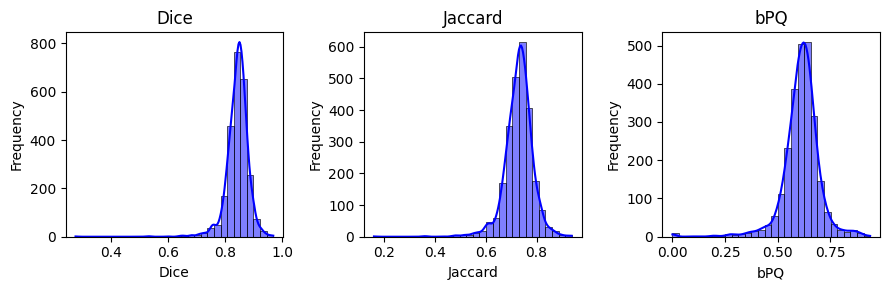

In [123]:
plot_all_metrics(df_metrics)

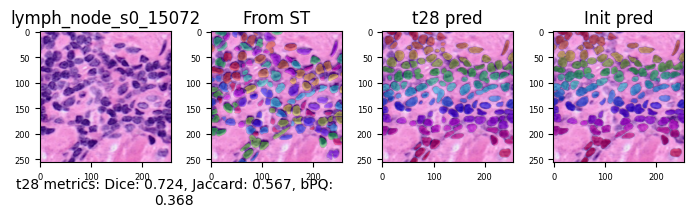

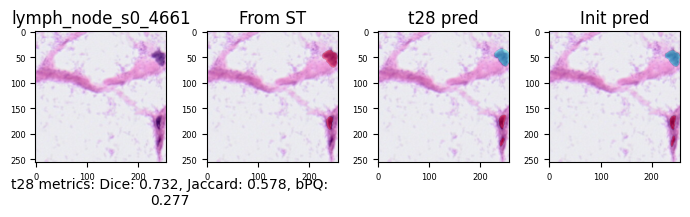

In [124]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [125]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for ovary_s0

In [126]:
slide_id = "ovary_s0"

In [127]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
244     ovary_s0_2251  0.712139  0.552962  0.340179   
277     ovary_s0_2358  0.701639  0.540404  0.298488   
281     ovary_s0_2362  0.742913  0.590980  0.455584   
318     ovary_s0_2468  0.766207  0.621018  0.438107   
330     ovary_s0_2480  0.757232  0.609311  0.502024   
...               ...       ...       ...       ...   
10209  ovary_s0_21383  0.888734  0.799750  0.637126   
10212  ovary_s0_21386  0.888289  0.799029  0.605514   
10216  ovary_s0_21496  0.896438  0.812312  0.670875   
10219  ovary_s0_21499  0.853084  0.743807  0.563002   
10224  ovary_s0_21612  0.876125  0.779558  0.628446   

                                   type_proba_per_nuclei  
244    {'Stromal': 0.9954058177712009, 'Other': 0.827...  
277    {'Background': 0.9999999930555556, 'Immune': 0...  
281    {'Stromal': 0.9170984408440496, 'Other': 0.855...  
318    {'Other': 0.9421965263456848, 'Stromal': 0.816...  
330    {'Other': 0.9999999920634921, 'Stromal': 0.797...  
...                                                  ...  
10209  {'Epithelial': 0.9784482716446196, 'Immune': 0...  
10212  {'Epithelial': 0.9302325509284298, 'Immune': 0...  
10216  {'Epithelial': 0.9499999881250002, 'Immune': 0...  
10219  {'Epithelial': 0.8814814749519891, 'Immune': 0...  
10224  {'Epithelial': 0.8999999955, 'Immune': 0.99999...  

[1707 rows x 5 columns]

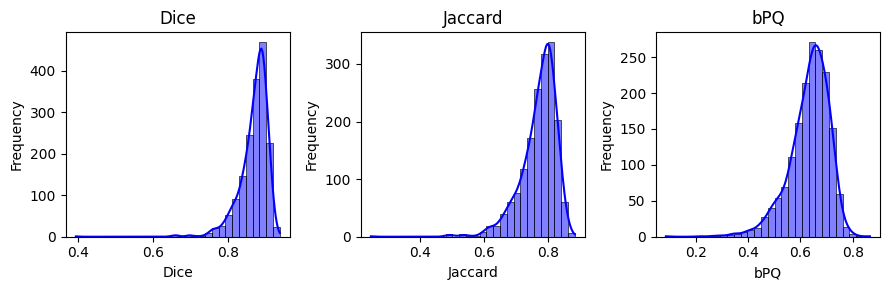

In [128]:
plot_all_metrics(df_metrics)

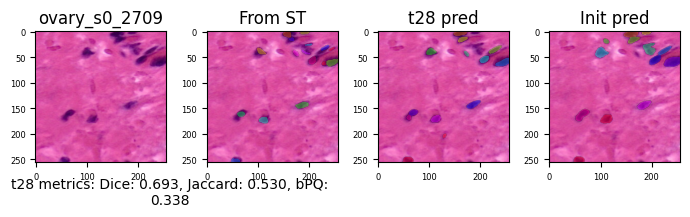

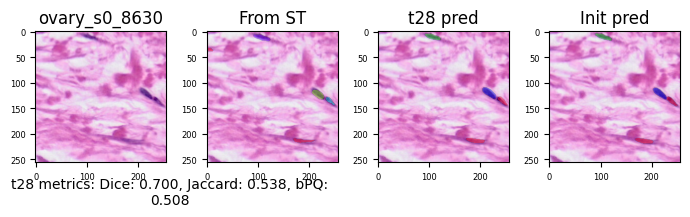

In [129]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [130]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for ovary_s1

In [131]:
slide_id = "ovary_s1"

In [132]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
4        ovary_s1_366  0.680945  0.516237  0.423431   
16       ovary_s1_378  0.554385  0.383494  0.171886   
18       ovary_s1_380  0.774149  0.631519  0.631752   
29       ovary_s1_524  0.874352  0.776755  0.604625   
33       ovary_s1_528  0.864177  0.760838  0.673403   
...               ...       ...       ...       ...   
25881  ovary_s1_35163  0.798620  0.664752  0.409844   
25884  ovary_s1_35166  0.832599  0.713208  0.623196   
25886  ovary_s1_35168  0.786667  0.648352  0.642027   
25922  ovary_s1_35314  0.854199  0.745503  0.617422   
25953  ovary_s1_35348  0.861281  0.756360  0.645959   

                                   type_proba_per_nuclei  
4      {'Epithelial': 0.9999999951923078, 'Stromal': ...  
16     {'Stromal': 0.9159663839888896, 'Immune': 0.99...  
18     {'Immune': 0.9919999960320001, 'Stromal': 0.99...  
29     {'Epithelial': 0.9921568588542868, 'Immune': 0...  
33     {'Epithelial': 0.9895833230251737, 'Immune': 0...  
...                                                  ...  
25881                    {'Stromal': 0.9015543994738114}  
25884                    {'Stromal': 0.9999999976076556}  
25886                    {'Stromal': 0.9961977148433547}  
25922                    {'Stromal': 0.9782608589319473}  
25953  {'Stromal': 0.8749999931640625, 'Immune': 0.75...  

[4451 rows x 5 columns]

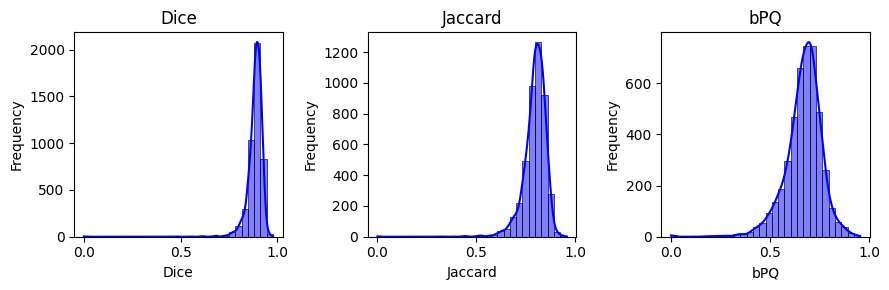

In [133]:
plot_all_metrics(df_metrics)

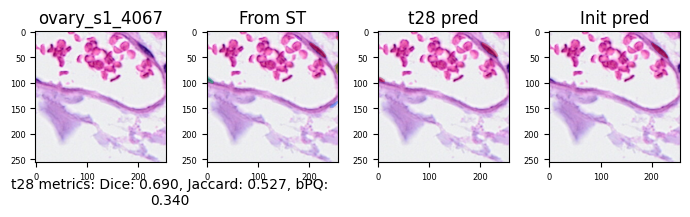

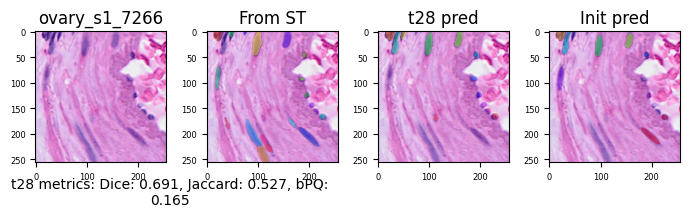

In [134]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [135]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for prostate_s0

In [136]:
slide_id = "prostate_s0"

In [137]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
12      prostate_s0_4057  0.777433  0.635903  0.528210   
23      prostate_s0_4068  0.732240  0.577586  0.573532   
45      prostate_s0_4090  0.796519  0.661846  0.627570   
81      prostate_s0_4126  0.796644  0.662018  0.546332   
84      prostate_s0_4129  0.840321  0.724615  0.676867   
...                  ...       ...       ...       ...   
13526  prostate_s0_32226  0.826886  0.704863  0.602253   
13547  prostate_s0_32356  0.855787  0.747926  0.602222   
13548  prostate_s0_32357  0.861812  0.757179  0.679810   
13553  prostate_s0_32362  0.768603  0.624172  0.511976   
13554  prostate_s0_32363  0.800450  0.667292  0.513406   

                                   type_proba_per_nuclei  
12     {'Other': 0.9645390002514964, 'Stromal': 0.999...  
23                       {'Stromal': 0.9882352883044984}  
45     {'Stromal': 0.9875518631221915, 'Immune': 0.94...  
81     {'Other': 0.9550561744097967, 'Stromal': 0.971...  
84     {'Immune': 0.9833333306018519, 'Other': 0.8765...  
...                                                  ...  
13526  {'Stromal': 0.9811320662157352, 'Other': 0.974...  
13547  {'Stromal': 0.9928741069052872, 'Immune': 0.98...  
13548                    {'Stromal': 0.9999999915254238}  
13553  {'Epithelial': 0.8804347730387525, 'Immune': 0...  
13554  {'Epithelial': 0.9217391264272212, 'Stromal': ...  

[2452 rows x 5 columns]

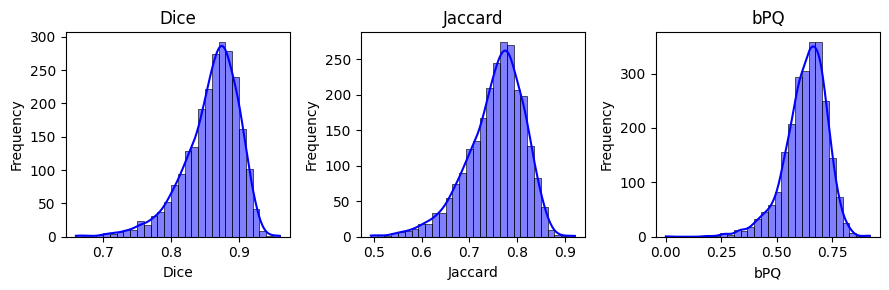

In [138]:
plot_all_metrics(df_metrics)

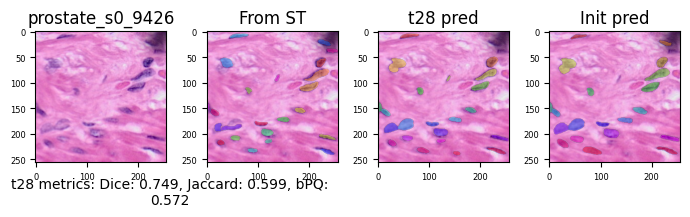

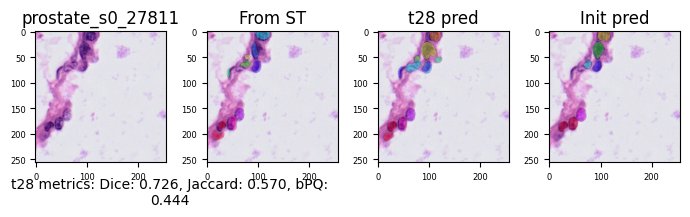

In [139]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [140]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)

## Analyze for cervix_s0

In [141]:
slide_id = "cervix_s0"

In [142]:
df_metrics = build_df_metrics(output_cellvit_folder, slide_id)
df_metrics = df_metrics[df_metrics['patch_id'].isin(slide_ids_test)]
df_metrics

patch_id      Dice   Jaccard       bPQ  \
24      cervix_s0_3002  0.828591  0.707346  0.539307   
25      cervix_s0_3003  0.832512  0.713080  0.619554   
26      cervix_s0_3004  0.850730  0.740235  0.598538   
27      cervix_s0_3005  0.832487  0.713042  0.578266   
35      cervix_s0_3013  0.826856  0.704820  0.630437   
...                ...       ...       ...       ...   
36541  cervix_s0_46223  0.863207  0.759335  0.641529   
36542  cervix_s0_46224  0.803613  0.671700  0.453138   
36573  cervix_s0_46413  0.684139  0.519917  0.379983   
36575  cervix_s0_46415  0.751945  0.602493  0.630391   
36580  cervix_s0_46420  0.777616  0.636147  0.557803   

                                   type_proba_per_nuclei  
24     {'Stromal': 0.934782603615312, 'Immune': 0.941...  
25     {'Stromal': 0.9999999981751825, 'Epithelial': ...  
26                    {'Epithelial': 0.9906541963490262}  
27     {'Epithelial': 0.9333333208888891, 'Stromal': ...  
35     {'Immune': 0.9771689453097309, 'Stromal': 0.99...  
...                                                  ...  
36541  {'Other': 0.9166666557539684, 'Stromal': 0.925...  
36542  {'Other': 0.9999999871794873, 'Immune': 0.9676...  
36573  {'Epithelial': 0.8226415063296547, 'Other': 0....  
36575  {'Epithelial': 0.935323378431227, 'Other': 0.7...  
36580  {'Other': 0.9833333169444448, 'Immune': 0.9949...  

[7099 rows x 5 columns]

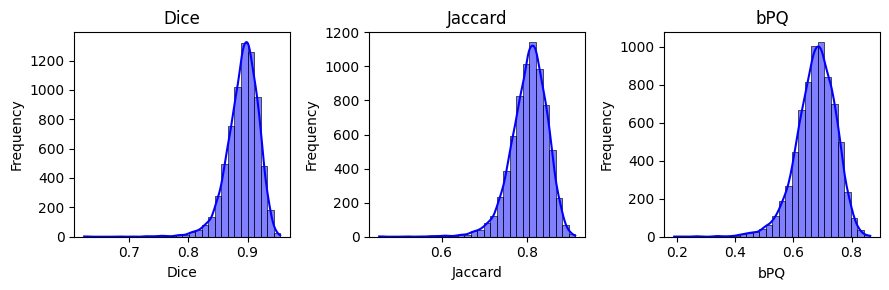

In [143]:
plot_all_metrics(df_metrics)

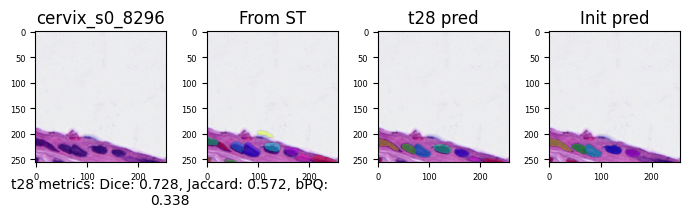

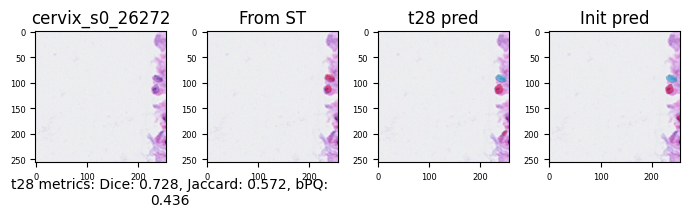

In [144]:
plot_check_seg(df_metrics=df_metrics, 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(data_folder, "images.zip"),
            mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            slide_id=slide_id,
            save_folder=None)

In [145]:
# plot_patch_seg(patch_id=486, 
#             df_metrics=df_metrics, 
#             img_zip_path=os.path.join(data_folder, "images.zip"),
#             mask_zip_path=os.path.join(data_folder, ct_id, "ALL", "labels.zip"),
#             inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             init_cellvit_path=os.path.join(init_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
#             slide_id=slide_id,
#             save_folder=None)